In [ ]:
# ..... get cell types using Mantri et al markers ..... #
# markers for CM-2 overlaps with erythrocytes, most markers have low specificity

In [2]:
library(SingleCellExperiment)
library(MetaMarkers)
library(Seurat)
library(data.table)
library(dplyr)

In [3]:
# get list of samples
stages = c(rep('stage23', 2), rep(c('stage28', 'stage32'), each = 3))
samples = c('sample3', 'sample10', 'sample5', 'sample10', 'sample11',
           'sample5', 'sample10', 'sample12')

In [4]:
# load markers
markers = fread('~/septation/markers/Mantri/Mantri_celltype_markers.csv.gz')
ctypes = unique(markers$cell_type)
markers$rank = rep(1:(dim(markers)[1]/length(ctypes)), length(ctypes))
markers <- markers[markers$cell_type!='TMSB4X high cells',]
markers[1:2,]

# tibble of group, cell_type, gene, rank
top_markers = as_tibble(markers[which(markers$rank<=100),c('group', 'cell_type', 'gene', 'rank', 'fold_change', 'auroc')])
top_markers[1:2,]

group cell_type        gene  fold_change auroc     log_fdr   population_size
1 all   Cardiomyocytes-1 TPM4  3.122102    0.8517201 -1202.058 1873           
2 all   Cardiomyocytes-1 MYH15 3.667237    0.8460475 -1163.582 1873           
  population_fraction average_expression se_expression detection_rate
1 0.1326863            9733.35           105.4473      0.9951949     
2 0.1326863           12210.20           252.5924      0.9861185     
  fold_change_detection precision recall    rank
1 1.324510              0.1685353 0.9951949 1   
2 1.402129              0.1766788 0.9861185 2

group cell_type        gene  rank fold_change auroc    
1 all   Cardiomyocytes-1 TPM4  1    3.122102    0.8517201
2 all   Cardiomyocytes-1 MYH15 2    3.667237    0.8460475

In [5]:
head(top_markers$gene[top_markers$cell_type=='Cardiomyocytes-2'], n = 30)

[1] "HBA1"     "HBBR.1"   "HBM"      "HBBR"     "HBZ"      "MYL2"    
 [7] "ACTC1"    "TNNC1"    "TPM4"     "GAPDH"    "MYL3"     "TMSB4X"  
[13] "MYH15"    "HSPB1"    "UBC"      "LDHB"     "ITGB1BP3" "STMN1"   
[19] "YBX1"     "ATP5MC1"  "TUBA1B"   "ACTA1"    "MYL9"     "ATP5MC3" 
[25] "CIRBP"    "RPS2"     "TNNT2"    "PRDX1"    "RPL19"    "RPL6"

In [6]:
# load seurat object
pb = txtProgressBar(min = 0, max = length(samples), initial = 0)

for(id in 1:length(samples)){
    sce = readRDS(paste0(stages[id], '_', samples[id], '_data.rds'))
    # sce
    
    # get SCE object
    sc3 = SingleCellExperiment(list(counts = LayerData(sce, assay = 'RNA', layer = 'counts')))
    colData(sc3) <- DataFrame(sce@meta.data)
    assay(sc3, "cpm") = convert_to_cpm(assay(sc3))
    
    # predict cell type neighborhood
    ct_scores = score_cells(log1p(cpm(sc3)), top_markers)
    ct_enrichment = compute_marker_enrichment(ct_scores)
    ct_pred = assign_cells(ct_scores)
    
    # ct_pred[1:3,]
    # table(ct_pred$predicted)
    sc3$celltype_Mantri <- ct_pred$predicted
    sce$celltype_Mantri <- ct_pred$predicted

    # table(sce$celltype_Mantri[sce$seurat_clusters==0])
    # sce@meta.data[1,]

    # save
    write.table(ct_pred, file = paste0('annotations/', stages[id], '_', samples[id], '_Mantri_celltypes.csv'),
            sep = ',', row.names = T, col.names = T, quote = F)

    setTxtProgressBar(pb, id)

}

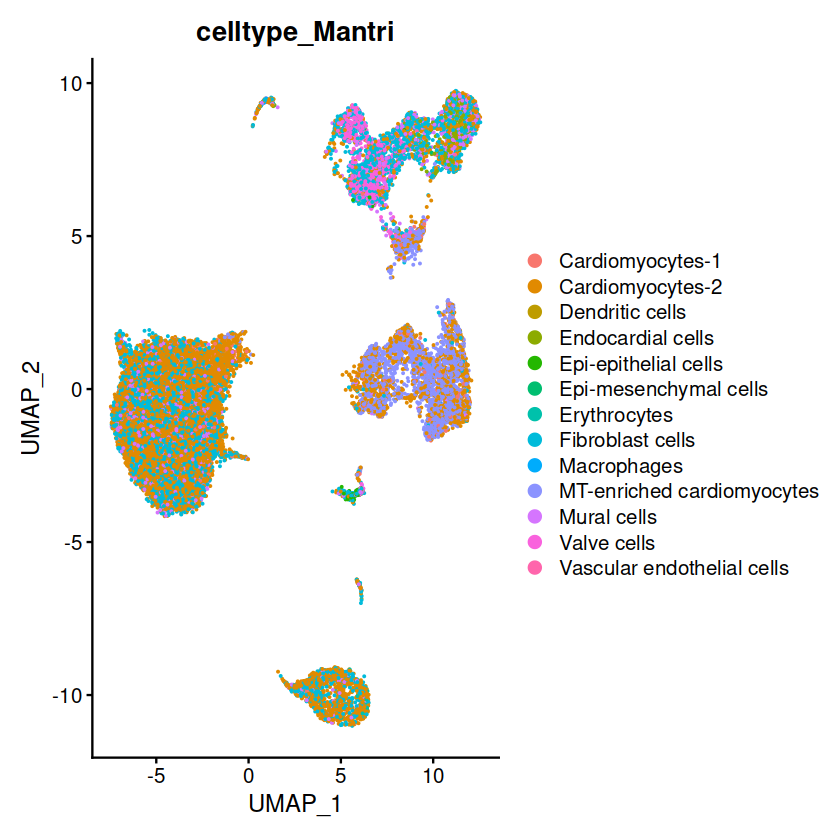

In [24]:
DimPlot(sce, reduction = 'umap', group.by = 'celltype_Mantri')

In [48]:
# save file
saveRDS(sce, file = paste0(stages[id], '_', samples[id], '_data.rds'))